In [31]:
using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings

# TS (tanh-sinh) integration module 
#### (GPU compatible too)
#### revised from https://github.com/machakann/DoubleExponentialFormulas.jl

In [32]:
function samplepoint_will(t::Float64)
    #println("t: ", t)
    sinht = sinh(t)
    ϕ = tanh(sinht*π/2)
    ϕ′ = (cosh(t)*π/2)/cosh(sinht*π/2)^2
    return ϕ, ϕ′
end


using LinearAlgebra: norm
function estimate_error_will(prevI, I)
    ε = eps(Float64)
    M = 20
    return M*norm(I - prevI)^2 + norm(I)*ε
end


function qts_will(f::Function, h0::Float64, maxlevel::Integer=6)

    #@assert maxlevel > 0
    #@assert h0 > 0
    
    T = Float64
    
    x0, w0 = samplepoint_will(0.0)  #origin
    Σ = f(x0)*w0
   
    k = 1
    while true
        t = k*h0
        xk, wk = samplepoint_will(t)  # Note that t
        1 - xk ≤ eps(T) && break   # xk is too close to 1, the upper bound of integral
        wk ≤ floatmin(T) && break  # wk is too small, series trucated
        
        Σ += (f(xk) + f(-xk)) * wk
        k += 1    # step is either 1 for level = 0

    end    
    I = h0*Σ
    E = zero(eltype(I))
    
    for level in 1:maxlevel
        
        k = 1
        h = h0/2^level
        while true
            t = k*h
            xk, wk = samplepoint_will(t)  # Note that t
            1 - xk ≤ eps(T) && break   # xk is too close to 1, the upper bound of integral
            wk ≤ floatmin(T) && break  # wk is too small, series trucated

            Σ += (f(xk) + f(-xk)) * wk
            k += 2    # step is either 1 for level = 0

        end     
        
        prevI = I
        I = h*Σ
        E = estimate_error_will(prevI, I)
        ##tol = max(norm(I)*rtol, atol)
        tol = norm(I)*sqrt(eps(T))
        !(E > tol) && break  
        #println(level)
    end
        
    return I
    #return I, E

end

qts_will (generic function with 2 methods)

In [202]:
# In contrast to qts_will which integrates from -1 to 1
# QTS_will integrates from a to b

function QTS_will(f::Function, a::Float64, b::Float64)

    s = (b + a)/2
    t = (b - a)/2

    #print("t:", t)
    #I, E = q.qts(u -> f(s + t*u); atol=atol/t, rtol=rtol)
    #I*t, E*t
    
    h0 = 1.0
    maxlevel = 6 # A large maxlevel may be slow if the integral does not converge...
    I = qts_will(u-> f(s+t*u), h0, maxlevel)
    return I*t   

end 

QTS_will (generic function with 1 method)

In [78]:
# test
gg(x) = sin(x)^2
gg(x) = sqrt(1-x)

QTS_will(gg, -3.5, 1.0)

6.363961030680568

# Brent's method for root finding

In [34]:
# Root finding

const _ECONVERGED = Symbol("converged")
const _ECONVERR   = Symbol("err")

const _iter = 100
const _xtol = 2e-12       #2e-12
const _rtol = 4eps()

"""Conditional checks for intervals in methods involving bisection"""
function _bisect_interval(a::Real, b::Real, fa::Real, fb::Real)

    if fa*fb > 0 
        error("f(a) and f(b) must have different signs")
    end
    root = 0.0
    status = _ECONVERR

    # Root found at either end of [a,b]
    if fa == 0
        root = a
        status = _ECONVERGED
    elseif fb == 0
        root = b
        status = _ECONVERGED
    end

    root, status
end

#typeof(_ECONVERGED)

function brentq(f, a::Real, b::Real)
    xtol=_xtol
    rtol=_rtol
    maxiter=_iter
    disp=true
    """
    Modified from: 
    https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/optimize/root_finding.py#L6
    with fixed arguments. 
    
    Find a root of a function in a bracketing interval using Brent's method
    adapted from Scipy's brentq.
    Uses the classic Brent's method to find a zero of the function `f` on
    the sign changing interval [a , b].
    `f` must be jitted via numba.
    Parameters
    ----------
    f : jitted and callable
        Python function returning a number.  `f` must be continuous.
    a : number
        One end of the bracketing interval [a,b].
    b : number
        The other end of the bracketing interval [a,b].
    args : tuple, optional(default=())
        Extra arguments to be used in the function call.
    xtol : number, optional(default=2e-12)
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        atol=xtol, rtol=rtol)``, where ``x`` is the exact root. The
        parameter must be nonnegative.
    rtol : number, optional(default=4*np.finfo(float).eps)
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        atol=xtol, rtol=rtol)``, where ``x`` is the exact root.
    maxiter : number, optional(default=100)
        Maximum number of iterations.
    disp : bool, optional(default=True)
        If True, raise a RuntimeError if the algorithm didn't converge.
    Returns
    -------
    results : namedtuple
    """
    ## if xtol <= 0
    ##     error("xtol is too small (<= 0)")
    ## elseif maxiter < 1
    ##     error("maxiter must be greater than 0")
    ## end
    
    # Convert to float
    xpre = float(a)
    xcur = float(b)

    fpre = f(xpre)
    fcur = f(xcur)
    funcalls = 2
    
    # CM added
    xblk = xpre
    fblk = fpre
    spre = scur = xcur - xpre

    root, status = _bisect_interval(xpre, xcur, fpre, fcur)
    
    # Check for sign error and early termination
    if status == _ECONVERGED
        itr = 0
    else
        # Perform Brent's method
        for itr in 0:maxiter
            
            if fpre * fcur < 0
                xblk = xpre
                fblk = fpre
                spre = scur = xcur - xpre
            end
            
            if abs(fblk) < abs(fcur)
                xpre = xcur
                xcur = xblk
                xblk = xpre

                fpre = fcur
                fcur = fblk
                fblk = fpre
            end

            delta = (xtol + rtol * abs(xcur)) / 2
            sbis = (xblk - xcur) / 2

            # Root found
            if fcur == 0 || (abs(sbis) < delta)
                status = _ECONVERGED
                root = xcur
                itr += 1
                break
            end

            if (abs(spre) > delta) && (abs(fcur) < abs(fpre))
                if xpre == xblk
                    # interpolate
                    stry = -fcur * (xcur - xpre) / (fcur - fpre)
                else
                    # extrapolate
                    dpre = (fpre - fcur) / (xpre - xcur)
                    dblk = (fblk - fcur) / (xblk - xcur)
                    stry = -fcur * (fblk * dblk - fpre * dpre) / (dblk * dpre * (fblk - fpre)) 
                end

                if (2 * abs(stry) < min(abs(spre), 3 * abs(sbis) - delta))
                    # good short step
                    spre = scur
                    scur = stry
                else
                    # bisect
                    spre = sbis
                    scur = sbis
                end
            else
                # bisect
                spre = sbis
                scur = sbis
            end

            xpre = xcur
            fpre = fcur
            if abs(scur) > delta
                xcur += scur
            else
                
                xcur += sbis > 0 ? delta : -delta
            end
            
            fcur = f(xcur)
            funcalls += 1
        end
    end

    ## if disp && status == _ECONVERR
    ##     error("Failed to converge")
    ## end

    #return _results((root, funcalls, itr, status))
    return root
end


# test
g(x) = x^2-1
brentq(g, 0, 10)

1.0000000000002276

# Default parameters 

In [35]:
const rho = 1.5
const gamma = 5000.0
const beta = (1-1/gamma^2)^(1/2)
const lamb = 0.01/rho

const phi_m = 0.5/rho

sigma_z = 50e-6
sigma_x = 50e-6

5.0e-5

# Field definitions

In [36]:
function f_root_case_D(a::Float64, z::Float64, x::Float64, beta::Float64, lamb::Float64) 
    return a .+ 1/2 * (lamb .- beta* sqrt.(lamb.^2 .+ x.^2 .+ 4*(1+x)*sin.(a).^2 .+ 2*lamb*sin.(2*a))) .- z
end

function alpha_exact_case_D_brentq(z::Float64, x::Float64, beta::Float64, lamb::Float64)
    f_root_case_D_x(a) = f_root_case_D(a, z, x, beta, lamb)
    #return find_zero(f_root_case_D_x, (-0.1,1), Roots.Brent())
    return brentq(f_root_case_D_x, -0.1, 1)
end

alpha_exact_case_D_brentq( 0.001, 0.001, beta, lamb )

0.18392662750161842

In [37]:
function Es_case_D(z::Float64, x::Float64, gamma::Float64, lamb::Float64)
    #if z == 0 && x == 0
    #    return 0  
    #end
    
    beta2 = 1-1/gamma^2
    beta = sqrt(beta2)

    alp = alpha_exact_case_D_brentq(z, x, beta, lamb)
    sin2a = sin(2*alp)
    cos2a = cos(2*alp)
    
    kap = (2*(alp - z) + lamb)/beta # kappa for case D
    
    N1 = cos2a - (1+x)
    N2 = lamb*cos2a + (1+x)*sin2a - beta*kap
    #println(N1)
    #println(N2)
    
    D = kap - beta*(lamb*cos2a + (1+x)*sin2a)
    #println(D)
    return N1*N2/D^3
end

Es_case_D (generic function with 1 method)

In [232]:
Es_case_D(0.0, 0.0, gamma, lamb)

5.0417237555250725e10

# QTS3: Main integrator using BP (break-points)

In [240]:
# Users can ignore this cell
# some inner code for substitution for QTS3 N2
    alp_vec = range(-1e-2, 1e-2, length = 4000)
    N2_vec = N2.(alp_vec)

    function find_crit_index(vec)

        #out = Vector{Int}()
        sign_now = sign(vec[1])
        for i in 2:length(vec)
            if sign(vec[i]) != sign_now
                return i
                #append!(out, i)
                #sign_now = sign(vec[i])
            end
        end
        return 0
        #return out
    end

    #crit_index_vec = find_crit_index(N2_vec)
    crit_index = find_crit_index(N2_vec)

    #if length(crit_index_vec) == 0
    if crit_index == 0
        alp_crit2_found = false
    else
        alp_crit2 = brentq(N2, alp_vec[crit_index-1], alp_vec[crit_index]) 
        #alp_crit2 = brentq(N2, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])   
        #alp_crit2 = brentq(N2, alp_vec[crit_index_vec[2]-1], alp_vec[crit_index_vec[2]])  
        #println("crit2:", alp_crit2)
    end

LoadError: UndefVarError: N2 not defined

In [235]:
# function "find_zero" is under Roots
# Roots does NOT work with GPU by default
using Roots 

function QTS3(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, xp::Float64)
    
    ## define function here
    #sigma_x  = 50e-6
    #sigma_z  = 50e-6
    lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)
    
    iii(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho;
    zid = rho*(phi_m + lamb - beta*sqrt(lamb^2 + chi^2 + 4*(1 + chi)*sin(phi_m/2)^2 + 2*lamb*sin(phi_m)));
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2));
    
    #println("xp: ", xp)
    #println("zid: ", zid)
    #println("zod: ", zod)
    
#####################################
    # find critical alpha

    # These came from Es_case_D
    N1(alp::Float64) = cos(2*alp) - (1+chi)
    kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
    N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)

    #println("N1(1e-4): ", N1(1e-4))
    #println("N2(1e-4): ", N2(1e-4))
    
    alp_crit1_found = true
    alp_crit2_found = true
    
    # For N1 = 0 
    if chi > 0
        alp_crit1_found = false
    else
        alp_crit1 = acos(1+chi)/2
    end

    alp_crit2 = try find_zero(N2, 0)
    catch 
        alp_crit2_found = false
    end

    #println("alp_crit1: ", alp_crit1)
    #println("alp_crit2: ", alp_crit2)
    
    alp_crit1_usable = false
    alp_crit2_usable = false

    if alp_crit1_found == true
        z_crit1 = z_ob - 2*rho*(alp_crit1 + (lamb - beta*kap(alp_crit1))/2)  
        if (z_crit1 > z_ob - zid) && (z_crit1 < z_ob - zod)
            alp_crit1_usable = true
        end
    end

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2)  
        if (z_crit2 > z_ob - zid) && (z_crit2 < z_ob - zod)
            alp_crit2_usable = true
        end
    end        

    if (alp_crit1_usable == true) && (alp_crit2_usable == true)
        #println("Both crit points usable")

        # Use BP from both N1 and N2
        #zp1, zp2 = sort([z_crit1, z_crit2])
        #i1 = QTS_will(iii, z_ob - zid, zp1)
        #i2 = QTS_will(iii, zp1, zp2)
        #i3 = QTS_will(iii, zp2, z_ob - zod)
        # return i1+i2

        # Use BP from N2 only
        i1 = QTS_will(iii, z_ob - zid, z_crit2)
        i2 = QTS_will(iii, z_crit2, z_ob - zod)
        return i1+i2

    elseif (alp_crit1_usable == false) && (alp_crit2_usable == false)

        #println("Neither crit points usable... using zero instead")

        # Use zero as BP. This might introducing undesired spikes 
        #i1 = QTS_will(iii, z_ob - zid, 0.0)
        #i2 = isapprox(0.0, z_ob - zod; atol=1e-20) ? 0.0 : QTS_will(iii, 0.0, z_ob - zod)  
        #return i1+i2 
                    
        return QTS_will(iii, z_ob - zid, z_ob - zod)

        #return quadgk(z -> iii(z), z_ob - zid, z_ob - zod, rtol=1e-4)[1]

    elseif alp_crit1_usable == true
        #println(" only N1 BP usable ")
        zp1 = z_crit1
    else
        #println(" only N2 BP usable ")
        zp1 = z_crit2
    end

    i1 = QTS_will(iii, z_ob - zid, zp1)
    i2 = QTS_will(iii, zp1, z_ob - zod)
    
    return i1 + i2
    
    #return QTS_will(iii, z_ob - zid, z_ob - zod)
end 

QTS3 (generic function with 1 method)

In [236]:
QTS3(0.0, 0.0, gamma, lamb, 1e-6)

1.8515182009620213e10

## QT4: attempt to use Brent's method for N2 BP

In [237]:
function QTS4(z_ob::Float64, x_ob::Float64, xp::Float64)

    sigma_x  = 50e-6
    sigma_z  = 50e-6
    lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)
    
    # the integrand
    iii(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_2d(z,xp)
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho;
    zid = rho*(phi_m + lamb - beta*sqrt(lamb^2 + chi^2 + 4*(1 + chi)*sin(phi_m/2)^2 + 2*lamb*sin(phi_m)));
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2));
    
    #println("xp: ", xp)
    #println("zid: ", zid)
    #println("zod: ", zod)
    
#####################################
    # find critical alpha

    N1(alp::Float64) = cos(2*alp) - (1+chi)
    kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
    N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)
    DD(alp::Float64) = kap(alp) - beta*(lamb*cos(2*alp) + (1+chi)*sin(2*alp))
    
    #Es_of_alp(alp::Float64) = N1(alp)*N2(alp)/DD(alp)^3
    Es_of_alp(alp::Float64) = N2(alp)

    alp_vec = range(-5e-2, 5e-2, length = 10000)
    Es_of_alp_vec = Es_of_alp.(alp_vec)   
    
    # find at which indices of vec the sign changes
    # vec must be of length 2 or longer
    function find_crit_index(vec)

        out = Vector{Int}()
        sign_now = sign(vec[1])
        for i in 2:length(vec)
            if sign(vec[i]) != sign_now
                append!(out, i)
                sign_now = sign(vec[i])
            end
        end
        #println("Length(out):", length(out))
        return out
    end

    crit_index_vec = find_crit_index(Es_of_alp_vec)
    
    if length(crit_index_vec) == 0
        println("No crit alpha found")
        i1 = QTS_will(iii, z_ob - zid, 0.0)
        i2 = QTS_will(iii, 0.0, z_ob - zod)
        return i1 + i2
        
    elseif length(crit_index_vec) == 1
        println("1")
        alp_crit = brentq(Es_of_alp, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])
        z_crit = z_ob - 2*rho*(alp_crit + (lamb - beta*kap(alp_crit))/2) 
        i1 = QTS_will(iii, z_ob - zid, z_crit)
        i2 = QTS_will(iii, z_crit, z_ob - zod)
        return i1 + i2        
        
    elseif length(crit_index_vec) == 2
        println("2")
        alp_crit1 = brentq(Es_of_alp, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])
        alp_crit2 = brentq(Es_of_alp, alp_vec[crit_index_vec[2]-1], alp_vec[crit_index_vec[2]])    
        z_crit1 = z_ob - 2*rho*(alp_crit1 + (lamb - beta*kap(alp_crit1))/2) 
        z_crit2 = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2) 

        if z_crit1 < z_ob - zid
            println("oops!")
        end
        if z_crit2 > z_ob - zod
            println("oops!!!")
        end
        i1 = QTS_will(iii, z_ob - zid, z_crit1)
        i2 = QTS_will(iii, z_crit1, z_crit2)
        i3 = QTS_will(iii, z_crit2, z_ob - zod)

        return i1 + i2 + i3
        
    elseif length(crit_index_vec) == 3
        println("3")
        alp_crit1 = brentq(Es_of_alp, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])
        alp_crit2 = brentq(Es_of_alp, alp_vec[crit_index_vec[2]-1], alp_vec[crit_index_vec[2]])    
        alp_crit3 = brentq(Es_of_alp, alp_vec[crit_index_vec[3]-1], alp_vec[crit_index_vec[3]]) 
        z_crit1 = z_ob - 2*rho*(alp_crit1 + (lamb - beta*kap(alp_crit1))/2) 
        z_crit2 = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2) 
        z_crit3 = z_ob - 2*rho*(alp_crit3 + (lamb - beta*kap(alp_crit2))/2) 

        i1 = QTS_will(iii, z_ob - zid, z_crit1)
        i2 = QTS_will(iii, z_crit1, z_crit2)
        i3 = QTS_will(iii, z_crit2, z_crit3)
        i4 = QTS_will(iii, z_crit3, z_ob - zod)

        return i1 + i2 + i3 + i4
        
    elseif length(crit_index_vec) >= 4
        println("4")

        alp_crit1 = brentq(Es_of_alp, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])
        alp_crit2 = brentq(Es_of_alp, alp_vec[crit_index_vec[2]-1], alp_vec[crit_index_vec[2]])    
        alp_crit3 = brentq(Es_of_alp, alp_vec[crit_index_vec[3]-1], alp_vec[crit_index_vec[3]]) 
        alp_crit4 = brentq(Es_of_alp, alp_vec[crit_index_vec[4]-1], alp_vec[crit_index_vec[4]]) 
        z_crit1 = z_ob - 2*rho*(alp_crit1 + (lamb - beta*kap(alp_crit1))/2) 
        z_crit2 = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2) 
        z_crit3 = z_ob - 2*rho*(alp_crit3 + (lamb - beta*kap(alp_crit2))/2) 
        z_crit4 = z_ob - 2*rho*(alp_crit4 + (lamb - beta*kap(alp_crit2))/2) 
        
        if z_crit1 < z_ob - zid
            println("oops!")
        end
        if z_crit4 > z_ob - zod
            println("oops!!!")
        end
        i1 = QTS_will(iii, z_ob - zid, z_crit1)
        i2 = QTS_will(iii, z_crit1, z_crit2)
        i3 = QTS_will(iii, z_crit2, z_crit3)
        i4 = QTS_will(iii, z_crit3, z_crit4)
        i5 = QTS_will(iii, z_crit4, z_ob - zod)
        
        return i1 + i2 + i3 + i4 + i5
    
    end

    #result = 0.0

    #for i in 1:length(crit_index_vec)
    #    alp_crit = brentq(Es_of_alp, alp_vec[crit_index_vec[i]-1], alp_vec[crit_index_vec[i]])
    #    z_crit = z_ob - 2*rho*(alp_crit + (lamb - beta*kap(alp_crit))/2) 
    #    result += QTS_will(iii, z_ob - zid, z_crit1)
    #    ....
    #end    
    
    
    #return QTS_will(iii, z_ob - zid, z_ob - zod)
end 

QTS4 (generic function with 1 method)

In [238]:
QTS3(0.0, 0.0, gamma, lamb, 1e-6)

1.8515182009620213e10

In [239]:
QTS4(0.0, 0.0, 1e-6)

2


1.8502410457044693e10

In [374]:
nxp = 101
sigma_x  = 50e-6 
xp_max = 5*sigma_x 
xp_min = -5*sigma_x  
dxp = (xp_max - xp_min)/(101-1)

xp_vec = xp_min:dxp:xp_max

-0.00025:5.0e-6:0.00025

In [396]:
x_ob = 0
xp = xp_vec[1] 
chi = (x_ob - xp)/rho

N1(alp::Float64) = cos(2*alp) - (1+chi)
kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)
D(alp::Float64) = kap(alp) - beta*(lamb*cos(2*alp) + (1+chi)*sin(2*alp))
SS(alp::Float64) = N1(alp)*N2(alp)/D(alp)^3

SS(alp::Float64) = N2(alp)

    alp_crit1 = try find_zero(N1, 0)
    catch 
        alp_crit1_found = false
    end

    alp_crit2 = try find_zero(N2, 0)
    catch 
        alp_crit2_found = false
    end


alp_vec = range(-5e-2, 5e-2, length = 10000)
N1_vec = N1.(alp_vec)
N2_vec = N2.(alp_vec)
SS_vec = SS.(alp_vec);
#plot(alp_vec, N1_vec, label="N1")
#plot(alp_vec, N2_vec, label = "N2")
#plot(alp_vec, SS_vec, label = "SS")

# find at which indices of vec the sign changes
# vec must be of length 2 or longer
function find_crit_index(vec)

    out = Vector{Int}()
    sign_now = sign(vec[1])
    for i in 2:length(vec)
        if sign(vec[i]) != sign_now
            append!(out, i)
            sign_now = sign(vec[i])
        end
    end
    return out
end

crit_index_vec = find_crit_index(SS_vec)

alp_crit21 = brentq(SS, alp_vec[crit_index_vec[1]-1], alp_vec[crit_index_vec[1]])
alp_crit22 = brentq(SS, alp_vec[crit_index_vec[2]-1], alp_vec[crit_index_vec[2]])

0.006485172752735247

In [241]:
function compute_Ws(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #qvec is for testing only
    # "similar" does not work with tuple
    #qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #qvec[i] = QTS3(z_ob, x_ob, gamma, lamb, xp_vec[i])  # for testing
        sum += QTS3(z_ob, x_ob, gamma, lamb, xp_vec[i])   # for CPU only
        #sum += QTS4(z_ob, x_ob, xp_vec[i])   # for CPU only
        
        # sum += QTS2(z_ob, x_ob, xp_vec[i])
        #sum +=1.0
    end
    
    #return qvec
    return sum* dxp*beta^2/rho^2
end

compute_Ws (generic function with 1 method)

In [242]:
compute_Ws(0.0, 0.0, gamma, lamb, 101)

-144331.19794153157

In [131]:
qvec = compute_Ws( z_ob[34], -sigma_x,  gamma, lamb, 101);

In [200]:
qvec1 = compute_Ws( z_ob[45], -sigma_x,  gamma, lamb, 301);
qvec2 = compute_Ws( z_ob[46], -sigma_x,  gamma, lamb, 301);
qvec3 = compute_Ws( z_ob[47], -sigma_x,  gamma, lamb, 301);
qvec4 = compute_Ws( z_ob[48], -sigma_x,  gamma, lamb, 301);

In [157]:
nxp = 301    
sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max

-0.00025:1.6666666666666667e-6:0.00025

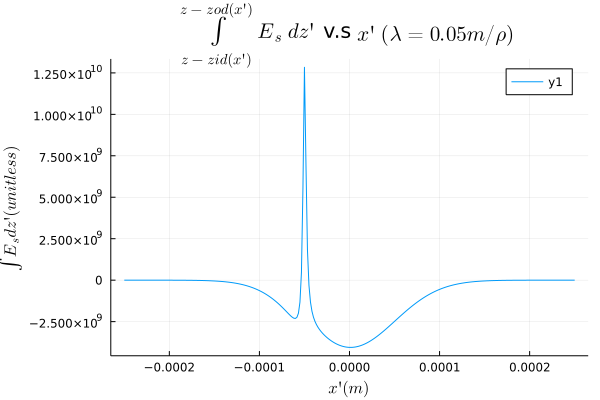

In [198]:
plot(xp_vec, qvec3)
#plot!(xp_vec, qvec2)
#plot!(xp_vec, qvec3)
plot!(xlabel=L"$x' (m)", ylabel=L"$\int E_s dz' (unitless)$", title=L"$\int^{z-zod(x')}_{z-zid(x')}  E_s ~ dz'$ v.s $x' ~(\lambda=0.05m/\rho)$ ")

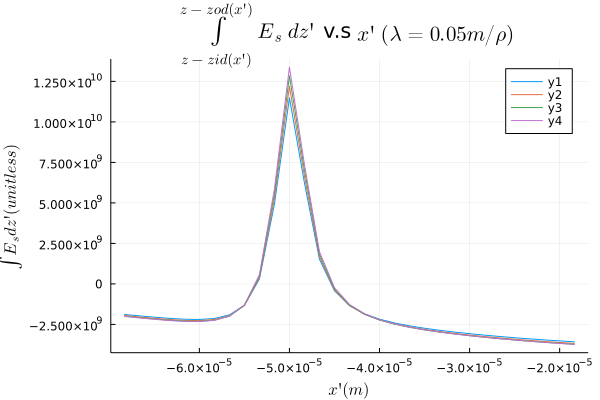

In [201]:
ix1 = 110
ix2 = 140
plot(xp_vec[ix1:ix2], qvec1[ix1:ix2])
plot!(xp_vec[ix1:ix2], qvec2[ix1:ix2])
plot!(xp_vec[ix1:ix2], qvec3[ix1:ix2])
plot!(xp_vec[ix1:ix2], qvec4[ix1:ix2])
plot!(xlabel=L"$x' (m)", ylabel=L"$\int E_s dz' (unitless)$", title=L"$\int^{z-zod(x')}_{z-zid(x')}  E_s ~ dz'$ v.s $x' ~(\lambda=0.05m/\rho)$ ")

# Multithreading computation of Ws(z,x)

In [244]:
@btime compute_Ws(0.0, 0.0, gamma, lamb, 101)

  109.426 ms (1049001 allocations: 16.01 MiB)


-144331.19794153157

In [245]:
using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [247]:
function Ws_case_D_multithread(; nz=21, nx=11)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-5*sigma_x, 5*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws(z_ob[i], x_ob[j], gamma, lamb, 101)
        end
    end
    return out
end

Ws_case_D_multithread (generic function with 1 method)

In [ ]:
@btime Ws_caseD_mat = Ws_case_D_multithread(nz=101, nx=101)

In [225]:
function Ws_case_D_multithread_lamb(lamb; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws(z_ob[i], x_ob[j], gamma, lamb, 301)
        end
    end
    return out
end

Ws_case_D_multithread_lamb (generic function with 1 method)

In [219]:
Ws_caseD_mat_lamb_0001 = Ws_case_D_multithread_lamb(0.001/rho, nz=101, nx=3);

In [214]:
Ws_caseD_mat_lamb_002 = Ws_case_D_multithread_lamb(0.02/rho, nz=101, nx=3);

In [215]:
Ws_caseD_mat_lamb_003 = Ws_case_D_multithread_lamb(0.03/rho, nz=101, nx=3);

In [217]:
Ws_caseD_mat_lamb_005 = Ws_case_D_multithread_lamb(0.05/rho, nz=101, nx=3);

In [226]:
Ws_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(lamb, nz=101, nx=5);

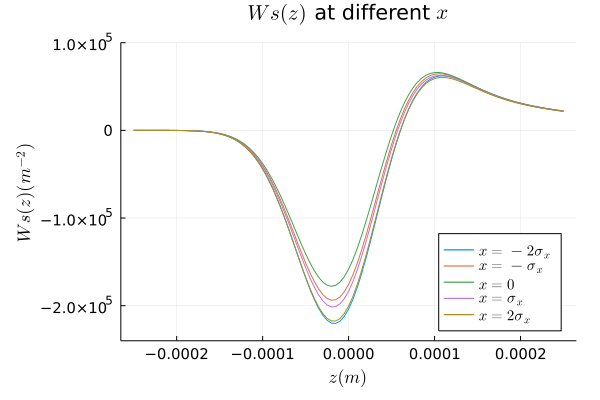

In [230]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Ws_caseD_mat_lamb_001[1:101], label=L"x =-2\sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[102:202], label=L"x = -\sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[203:303], label=L"x = 0")
plot!(z_ob, Ws_caseD_mat_lamb_001[304:404], label=L"x = \sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[405:505], label=L"x =2\sigma_x")

#plot!(z_ob, Ws_caseD_mat[5051:5151], label=L"x = 0")
#
#plot!(z_ob, Ws_caseD_mat[6061:6161], label=L"x =\sigma_x")

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z)$ at different $x$", ylims=(-2.4e5, 1e5))
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)


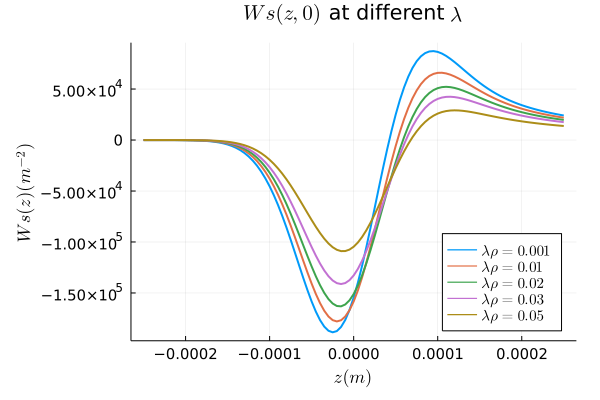

In [246]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda \rho=0.001")
plot!(z_ob, Ws_caseD_mat_lamb_001[203:303], linewidth=2, label=L"\lambda \rho=0.01")
plot!(z_ob, Ws_caseD_mat_lamb_002[1:101], linewidth=2, label=L"\lambda \rho=0.02")
plot!(z_ob, Ws_caseD_mat_lamb_003[1:101], linewidth=2, label=L"\lambda \rho=0.03")
plot!(z_ob, Ws_caseD_mat_lamb_005[1:101], linewidth=2, label=L"\lambda \rho=0.05")
#plot!(z_ob, Ws_caseD_mat[5051:5151], label=L"x = 0")
#
#plot!(z_ob, Ws_caseD_mat[6061:6161], label=L"x =\sigma_x")

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

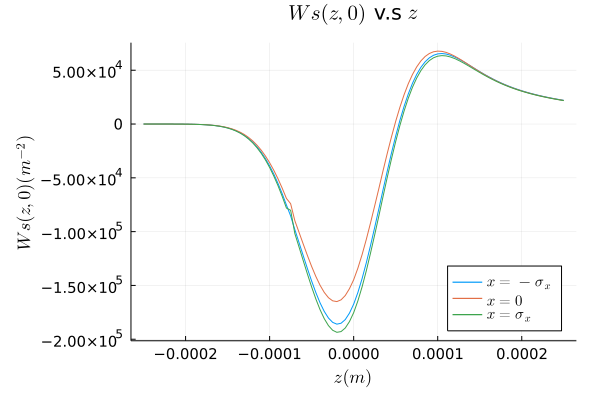

In [43]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Ws_caseD_mat[4041:4141], label=L"x =-\sigma_x")

plot!(z_ob, Ws_caseD_mat[5051:5151], label=L"x = 0")

plot!(z_ob, Ws_caseD_mat[6061:6161], label=L"x =\sigma_x")

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z,0) (m^{-2})$", title=L"$Ws(z,0)$ v.s $z$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

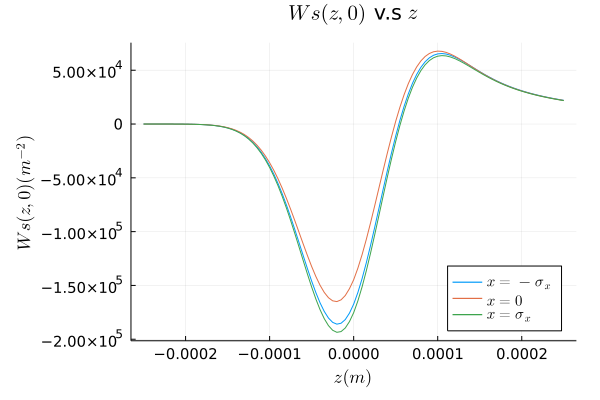

In [56]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Ws_caseD_mat[4041:4141], label=L"x =-\sigma_x")

plot!(z_ob, Ws_caseD_mat[5051:5151], label=L"x = 0")

plot!(z_ob, Ws_caseD_mat[6061:6161], label=L"x =\sigma_x")

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z,0) (m^{-2})$", title=L"$Ws(z,0)$ v.s $z$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

# Single threaded version (can be slow)

In [ ]:
# single-thread version along one x_ob
function Ws_case_D!(Ws_vec, zob_vec, x_ob, nxp) 
    for i = 1:length(zob_vec)
        Ws_vec[i] = compute_Ws(zob_vec[i], x_ob, nxp)
    end
    return nothing
end

@btime Ws_case_D!(Ws_vec, zob_vec, 0.0, 101)

  1.545 s (1712 allocations: 70.75 KiB)


In [25]:
N = 101
zob_vec = Array(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec=  similar(zob_vec);

In [28]:
Ws_case_D!(Ws_vec, zob_vec, 0.0, 101)

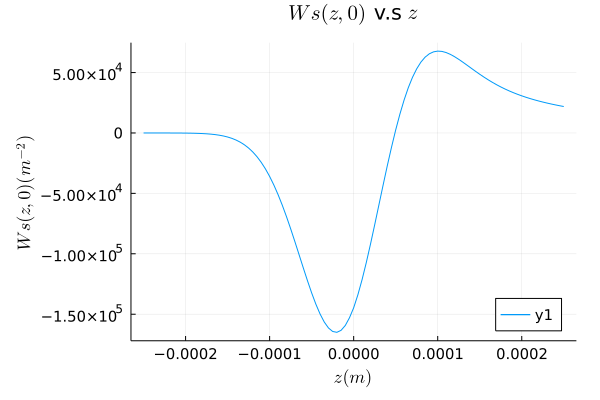

In [34]:
# at different $\lambda$ 

plot(zob_vec, Ws_vec)
plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z,0) (m^{-2})$", title=L"$Ws(z,0)$ v.s $z$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

In [24]:
N=256
zob_vec = Array(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec=  similar(zob_vec);

In [144]:
@btime Ws_case_D!(Ws_vec, zob_vec, 0.0, 101)

  18.526 s (0 allocations: 0 bytes)


In [159]:
N=2048
zob_vec = Array(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec=  similar(zob_vec);

In [160]:
@btime Ws_case_D!(Ws_vec, zob_vec, 0.0, 101)

  141.266 s (0 allocations: 0 bytes)


# Below is scratch

In [145]:
N=16
zob_vec = CuArray(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec = similar(zob_vec);

In [146]:
function Ws_case_D_z_gpu!(Ws_vec, zob_vec, x_ob, nxp)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
     
    for i = index:stride:length(zob_vec)
        Ws_vec[i] = compute_Ws(zob_vec[i], x_ob, nxp)
    end
    return nothing
end

@cuda threads=16 Ws_case_D_z_gpu!(Ws_vec, zob_vec, 0.0, 101)

Ws_case_D_z_gpu! (generic function with 1 method)

In [147]:
function bench_gpu2!(Ws_vec, zob_vec)
    CUDA.@sync begin
        @cuda threads=16 Ws_case_D_z_gpu!(Ws_vec, zob_vec, 0.0, 101)
    end
end

bench_gpu2! (generic function with 1 method)

In [148]:
@btime bench_gpu2!(Ws_vec, zob_vec)

  1.795 s (52 allocations: 3.27 KiB)


CUDA.HostKernel{typeof(Ws_case_D_z_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}, Float64, Int64}}(Ws_case_D_z_gpu!, CuContext(0x0000000002962a80, instance 3c84ba47563b564a), CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a)), CuFunction(Ptr{Nothing} @0x0000000016ce35b0, CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a))), CUDA.KernelState(Ptr{Nothing} @0x00002aab39c00000))

In [149]:
N=256
zob_vec = CuArray(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec = similar(zob_vec);

In [150]:
function bench_gpu2!(Ws_vec, zob_vec)
    CUDA.@sync begin
        @cuda threads=256 Ws_case_D_z_gpu!(Ws_vec, zob_vec, 0.0, 101)
    end
end

bench_gpu2! (generic function with 1 method)

In [151]:
@btime bench_gpu2!(Ws_vec, zob_vec)

  1.772 s (52 allocations: 3.27 KiB)


CUDA.HostKernel{typeof(Ws_case_D_z_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}, Float64, Int64}}(Ws_case_D_z_gpu!, CuContext(0x0000000002962a80, instance 3c84ba47563b564a), CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a)), CuFunction(Ptr{Nothing} @0x0000000016ce35b0, CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a))), CUDA.KernelState(Ptr{Nothing} @0x00002aab39c00000))

In [152]:
N=2048
zob_vec = CuArray(-5*sigma_z:10*sigma_z/(N-1):5*sigma_z)
Ws_vec = similar(zob_vec);

In [157]:
function bench_gpu2!(Ws_vec, zob_vec)
    CUDA.@sync begin
        @cuda threads=256 Ws_case_D_z_gpu!(Ws_vec, zob_vec, 0.0, 101)
    end
end

bench_gpu2! (generic function with 1 method)

In [158]:
@btime bench_gpu2!(Ws_vec, zob_vec)

  11.512 s (68 allocations: 3.75 KiB)


CUDA.HostKernel{typeof(Ws_case_D_z_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}, Float64, Int64}}(Ws_case_D_z_gpu!, CuContext(0x0000000002962a80, instance 3c84ba47563b564a), CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a)), CuFunction(Ptr{Nothing} @0x0000000016ce35b0, CuModule(Ptr{Nothing} @0x0000000013faa0e0, CuContext(0x0000000002962a80, instance 3c84ba47563b564a))), CUDA.KernelState(Ptr{Nothing} @0x00002aab39c00000))

In [4]:
f2(x::Float64) = 2*x
#qts_will_cu2(f) = 0.1

Z = Array([z for z in 1:1:3]);
Zcu = CuArray([z for z in 1:1:3]);

g(z) = sum_table(kaka, f2)

g.(Z) # works

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fa27835d150.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /global/homes/w/wlou1991/.julia/packages/GPUArrays/umZob/src/host/indexing.jl:56


3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [ ]:
g.(Zcu) # does not work

In [3]:
using LinearAlgebra: norm

# h0/2^level
# step is 1 for origin (xk=0), and 2 for other points (why?)
function generate_table_will(h::Float64, step::Int)
    T = Float64
    table = Tuple{T,T}[]
    k = 1
    while true
        t = k*h
        xk, wk = samplepoint_will(t)  # Note that t here is a number between 0 and 1
        1 - xk ≤ eps(T) && break   # xk is too close to 1, the upper bound of integral
        wk ≤ floatmin(T) && break  # wk is too small, series trucated
        push!(table, (xk, wk))
        k += step    # step is either 1 or 2 ?
    end
    reverse!(table)   # reversing the table so the first point is close to 1 instead of 0, but why?
    return table
end


function samplepoint_will(t::Float64)
    #println("t: ", t)
    sinht = sinh(t)
    ϕ = tanh(sinht*π/2)
    ϕ′ = (cosh(t)*π/2)/cosh(sinht*π/2)^2
    return ϕ, ϕ′
end


function QuadTS_will(maxlevel::Integer=5, h0::Float64=1.0)
    T = Float64
    @assert maxlevel > 0
    @assert h0 > 0
    origin = samplepoint_will(0.0)
    table0 = generate_table_will(h0, 1)
    tables = Vector{Tuple{T,T}}[]
    for level in 1:maxlevel
        h = h0/2^level  # split h0 into many (2^12) small intervals, h 
        table = generate_table_will(h, 2)   # not sure why step = 2 is used here, instead of step = 1
        push!(tables, table)
    end
    #return tables
    return (h0, origin, table0, Tuple(tables))
end




function estimate_error_will(prevI, I)
    ε = eps(Float64)
    M = 20
    return M*norm(I - prevI)^2 + norm(I)*ε
end

estimate_error_will (generic function with 1 method)

In [18]:
f2(x::Float64) = 1/(2-x)/(1-x)^(1/4)/(1+x)^(3/4)

f2 (generic function with 1 method)

In [4]:
h0, origin, table0, tables = QuadTS_will(6, 1.0);

In [5]:
t1 = CuArray(tables[1])
t2 = CuArray(tables[2])
t3 = CuArray(tables[3])
t4 = CuArray(tables[4])
t5 = CuArray(tables[5])
t6 = CuArray(tables[6]);
tables_cu = (t1, t2, t3, t4, t5, t6);

In [6]:
const h0_cu = h0 
const origin_cu = origin
table0_cu = CuArray(table0)

3-element CuArray{Tuple{Float64, Float64}, 1, CUDA.Mem.DeviceBuffer}:
 (0.999999999999957, 1.3581784274539059e-12)
 (0.9999774771924616, 0.0002662005137527172)
 (0.9513679640727469, 0.23002239451478873)

In [16]:
typeof(t1)

Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}

In [15]:
typeof(table0_cu)

CuArray{Tuple{Float64, Float64}, 1, CUDA.Mem.DeviceBuffer}

In [20]:
typeof(tables_cu)

NTuple{6, CuArray{Tuple{Float64, Float64}, 1, CUDA.Mem.DeviceBuffer}}

In [35]:
using CUDA

f2(x::Float64) = 2*x
#qts_will_cu2(f) = 0.1

Z = Array([z for z in 1:1:3]);
Zcu = CuArray([z for z in 1:1:3]);

g(z) = qts_will_cu2(f2)

g.(Z) # works

3-element Vector{Float64}:
 0.0
 0.0
 0.0